# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import copy
from torch import nn, optim
import torch.nn.functional as nnF
from torchvision import datasets, transforms, models
from PIL import Image

In [49]:
# Initialize user defined variables
# Image Size as required by the pre-trained network
img_ht = 224 # Height of the image in pixels
img_wd = 224 # Width of the image in pixels

# Parameters for reading images
batchsize = 32 # Batch size for no. of images to be read

# Following parameters are used for data augmentation during transformation
img_resize = 256 # Used for RandomResize of the image
drop_rate = 0.2 # Probability of dropping the image for training the model
flip_rate = 0.15 # Probability for flipping the image horizontally
rot_angle = 45 # Rotation Angle of image


# Select here the pre-trained pytorch model you want to use
model_name = 'vgg16' # Possible values are vgg16, vgg19, alexnet, densenet121, densenet161
if model_name == 'vgg16':
    input_size = 25088
elif model_name == 'vgg19':
    input_size = 25088
elif model_name == 'alexnet':
    input_size = 9216
elif model_name == 'densenet121':
    input_size = 1024
elif model_name == 'densenet161':
    input_size = 2208
else:
    print("Wrong selection of pytorch model")
    exit(1)    
# Following parameter are used for Classifier
#hidden_layers = None
#hidden_layers = [512, 256] # Hidden Layers for densenet121
# hidden_layers = [1024, 256] # Hidden Layers for densenet161
hidden_layers = [4096, 512] # Hidden Layers for vgg16, vgg19, alexnet

# Parameters for training the model
epoch = 16 # No of epochs for training the model
print_every = 16
lr = 0.001 # Learning Rate

# Select device to run the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)
print(hidden_layers)

# Create name of the checkpoint file based on the model to accomodate multiple models
checkpoint_file = model_name + '_chkpt.pth'
print("Checkpoint File = ", checkpoint_file)

cuda:0
[4096, 512]
Checkpoint File =  vgg16_chkpt.pth


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
# Specify the parent direcotry for images of flowers where training, validation and testing images are stored.
# Data is already subdivided into individual sub-directories for training, validation and test
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# TODO: Define your transforms for the training, validation, and testing sets

# For Training Data
# Use transforms to Horizontal Flip, Image Rotation, Random Resize Crop (224 pixel Square) then 
# convert the image to tensor and Normalize with provided means and standard deviation
train_transform = transforms.Compose([transforms.RandomRotation(rot_angle),
                                                    transforms.RandomResizedCrop(img_ht),
                                                    transforms.RandomHorizontalFlip(flip_rate),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# For Validation and Test Data
# Use transforms to Resize, Crop and then convert the image to Tensor
# Normalize the tensor with provided means and standard deviation
valid_transform = transforms.Compose([transforms.Resize(img_resize),
                                                    transforms.CenterCrop(img_ht),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
# Load the datasets after applying the transformations on images
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=valid_transform)

# Print the number of images in each data set
print("No of images in trainig data set = ", len(train_data))
print("No of images in validation data set = ", len(valid_data))
print("No of images in test data set = ", len(test_data))

# TODO: Using the image datasets and the trainforms, define the dataloaders
# Define the data loaders for loading images for training, validation and testing

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batchsize, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batchsize, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batchsize)

# Initialize the vaiables to track the lenght of the loaders (i.e. number of images / batch size)
len_train_loader = len(train_loader)
len_valid_loader = len(valid_loader)
len_test_loader = len(test_loader)

# 
print("Length of training loader = ", len_train_loader)
print("Length of validation loader = ", len_valid_loader)
print("Length of test loader = ", len_test_loader)

No of images in trainig data set =  6552
No of images in validation data set =  818
No of images in test data set =  819
Length of training loader =  205
Length of validation loader =  26
Length of test loader =  26


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [11]:
# Create a dictionary "cat_to_name" which contains category_id and category_nameof flowers
# by reading the data from json format file cat_to_name.json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Get the output size for the classifier variables
output_size = len(cat_to_name)

print(output_size)
print(cat_to_name)

102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54'

In [7]:
# NOT REQUIRED FOR PROJECT - This Cell is here only for testing 
# Run the test to make sure the data loader is loading the images properly, cat_to_name dictionary is loaded properly
# and labels are getting assigned from dictionary to images appropriately

images, labels = next(iter(train_loader))
rand_idx = np.random.randint(len(images))
print(rand_idx)
print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(), 
                                              train_data.classes[labels[rand_idx].item()], 
                                              cat_to_name[train_data.classes[labels[rand_idx].item()]]))

15
label: 57, class: 59, name: orange dahlia


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [8]:
# TODO: Build and train your network

# Step-1 Load a pre-trained network
# Load the pre-trained netowrkmodel you would like to use from torchvision
# Function to create classifer with user provided hyper parameters
# Input: input features, hidden layers, output features, drop rate
# Output: Classifier

def create_classifier(v_inp_size, v_hid_layers, v_out_size, p_drop):
    if v_hid_layers == None:
        v_hid_layers = []
    num_hid_layers = len(v_hid_layers)
    classifier = nn.Sequential()
    if num_hid_layers == 0:
        classifier.add_module('fc0', nn.Linear(v_inp_size, v_out_size))
    else:
        classifier = nn.Sequential()
        classifier.add_module('fc0', nn.Linear(v_inp_size, v_hid_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(p_drop))
        if num_hid_layers > 1:
            for i in range(num_hid_layers - 1):
                module_name = str(i + 1)
                classifier.add_module('fc' + module_name, nn.Linear(v_hid_layers[i], v_hid_layers[i+1]))
                classifier.add_module('relu' + module_name, nn.ReLU())
                classifier.add_module('drop' + module_name, nn.Dropout(p_drop))
        module_name = str(num_hid_layers)
        classifier.add_module('fc' + module_name, nn.Linear(v_hid_layers[num_hid_layers - 1], v_out_size))
    classifier.add_module('output', nn.LogSoftmax(dim = 1))
    return classifier

In [50]:
# Step-2 Define a new, untrained, feed_forward network as a classifier using ReLU activations and dropout
# Function builds a network using user provided model name, input & output features of the model, hidden layers, drop rate and
# learning rate. Assumes the default drop rate of 0.5 and learning rate f 0.001 if nor provided by user
# Input: Model Name, input features, output features, hidden layers, drop rate(optional), learning rate (optional)
# Output: model, criterion and optimizer

def build_network(v_model_name, v_input_size, v_output_size, v_hidden_layers, v_drop_rate = 0.5, v_lr = 0.001):
    if v_model_name == 'vgg16':
        v_model = models.vgg16(pretrained = True)
    elif v_model_name == 'vgg19':
        v_model = models.vgg19(pretrained = True)
    elif v_model_name == 'alexnet':
        v_model = models.alexnet(pretrained = True)
    elif v_model_name == 'densenet121':
        v_model = models.densenet121(pretrained = True)
    elif v_model_name == 'densenet161':
        v_model = models.densenet161(pretrained = True)
    else:
        print("Wrong selection of pytorch model")
        exit(1)    

    #print(model)
    
    # print(model)# Freeze Parameters of the pretrained model
    for param in v_model.parameters():
        param.requires_grad = False
    
    # Use your own classifier for the model
    myclassifier = create_classifier(v_input_size, v_hidden_layers, v_output_size, v_drop_rate)
    v_model.classifier = myclassifier
    print(v_model.classifier)

    # Define Criterion
    criterion = nn.NLLLoss()

    # Define Optimizer
    optimizer = optim.Adam(v_model.classifier.parameters(), v_lr)
    
    return v_model, criterion, optimizer

In [51]:
# Call build_network to build the network ready for training & validation
print("Selected pre-trained model = ", model_name)
print("Input Size for this model = ", input_size)
print("Hidden Layers selected  = ", hidden_layers)

model, criterion, optimizer = build_network(model_name, input_size, output_size, hidden_layers, drop_rate, lr)

print(criterion)
print(optimizer)
print(model)



Selected pre-trained model =  vgg16
Input Size for this model =  25088
Hidden Layers selected  =  [4096, 512]
Sequential(
  (fc0): Linear(in_features=25088, out_features=4096, bias=True)
  (relu0): ReLU()
  (drop0): Dropout(p=0.4)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.4)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (output): LogSoftmax()
)
NLLLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_si

In [52]:
# Step-3 & 4 Define a function for deep learning which will train the network and calculate accuracy on validation data
# Function tracks the loss and accuracy on validation dataset to determine best model weights
# Input: model, criterion, train loader, validation loader, epochs, print every, device (optional)
# Ouput: trained model

#Train the classifier layers using backpropagation using the pre-trained network to get features

def do_deep_learning(model, criterion, optimizer, t_loader, v_loader, epoch, print_every, device = 'cpu'):
    
    # Initialize variable to train the netwrok
    best_accuracy = 0
    #model_wts = copy.deepcopy(model.state_dict())

    # Move the model to available device default is cpu
    model.to(device)

    for ep in range(epoch):
        #    print("ep = ", ep, "epoch = ", epoch)
        # Kepp track of running loss for every epoch
        running_loss = 0
    
        # Get image and label from train loader i.e. training dataset
        for idx1, (train_input, train_label) in enumerate(t_loader):
            # Move the training images and labels to GPU if available        
            train_input, train_label = train_input.to(device), train_label.to(device)

            # Initialize Optimizer with zero gradients
            optimizer.zero_grad()

            # Forward pass, loss function and backward pass of the network
            train_output = model.forward(train_input)
            loss = criterion(train_output, train_label)
            loss.backward()
            optimizer.step()
        
            # Calculate running loss for this epoch
            running_loss += loss.item()

            # Check if validation phase needs to run
            if (idx1 + 1) % print_every == 0:
                model.eval()
                valid_loss = 0
                valid_accuracy = 0
                for idx2, (valid_input, valid_label) in enumerate(valid_loader):
                    optimizer.zero_grad()
                    valid_input, valid_label = valid_input.to(device), valid_label.to(device)
                    model.to(device)
                    with torch.no_grad():
                        valid_output = model.forward(valid_input)
                        valid_loss = criterion(valid_output, valid_label)
                        ps = torch.exp(valid_output)
                        equality = (valid_label.data == ps.max(dim=1)[1])
                        valid_accuracy += equality.type_as(torch.FloatTensor()).mean()
                valid_loss = valid_loss / len_valid_loader
                valid_accuracy = valid_accuracy / len_valid_loader
            
                print("Epoch: {}/{}.... ".format(ep+1, epoch), "Training Loss: {:.4f}.... ".format(running_loss/print_every),
                  "Validation Loss: {:.4f}.... ".format(valid_loss), "Validation Accuracy: {:.2f}".format(valid_accuracy * 100))
                if valid_accuracy > best_accuracy:
                    best_accuracy = valid_accuracy
                running_loss = 0
                model.train()
            
    print("Training and Validation Complete")        
    print("Best Accuracy achieved = {:.4f}..... ".format(best_accuracy * 100))

    return model

In [53]:
# Train the model and Validate on validation data set
model = do_deep_learning(model, criterion, optimizer, train_loader, valid_loader, epoch, print_every, device)

Epoch: 1/16....  Training Loss: 5.0289....  Validation Loss: 0.1614....  Validation Accuracy: 10.40
Epoch: 1/16....  Training Loss: 4.4458....  Validation Loss: 0.1614....  Validation Accuracy: 13.10
Epoch: 1/16....  Training Loss: 4.1884....  Validation Loss: 0.1386....  Validation Accuracy: 16.36
Epoch: 1/16....  Training Loss: 3.9072....  Validation Loss: 0.1067....  Validation Accuracy: 22.85
Epoch: 1/16....  Training Loss: 3.7080....  Validation Loss: 0.1221....  Validation Accuracy: 30.40
Epoch: 1/16....  Training Loss: 3.5472....  Validation Loss: 0.0961....  Validation Accuracy: 33.83
Epoch: 1/16....  Training Loss: 3.3344....  Validation Loss: 0.1203....  Validation Accuracy: 38.93
Epoch: 1/16....  Training Loss: 3.1918....  Validation Loss: 0.0902....  Validation Accuracy: 40.83
Epoch: 1/16....  Training Loss: 3.1080....  Validation Loss: 0.0838....  Validation Accuracy: 44.81
Epoch: 1/16....  Training Loss: 2.6458....  Validation Loss: 0.1007....  Validation Accuracy: 51.28


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [54]:
# TODO: Do validation on the test set
# Function to validate the trained model on test data set
# Input: Trained Model, Data Loader for the test data set, device
# Ouput: Percentage Correct Prediction by the model
def validation_on_testset(model, dataloader, device = 'cpu'):
    correct = 0.0
    total = 0
    model.to(device)

    with torch.no_grad():
        for test_input, test_label in dataloader:
            test_input, test_label = test_input.to(device), test_label.to(device)
            test_output = model(test_input)
            _, predicted = torch.max(test_output.data, 1)
            total += test_label.size(0)
            correct += (predicted == test_label).sum().item()
    return (correct / total)


In [70]:
# Use the Trained model to measure accuracy of prediction on test dataset
correct_pred = validation_on_testset(model, test_loader, device)

print("Accuracy of the network on Test Images = {:.2f}....".format(correct_pred * 100))

Accuracy of the network on Test Images = 71.55....


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [60]:
# TODO: Save the checkpoint
# Save the model architecture and state dictionary of the trained model into a file
print(checkpoint_file)
model.class_to_idx = train_data.class_to_idx
checkpoint = {'model_name': model_name,
              'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': hidden_layers,
              'drop_rate': drop_rate,
              'lr': lr,
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, checkpoint_file)

vgg16_chkpt.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [67]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# Funtion to rebuild the model and load it with trained weights from a file
# Input: checkpoint file of the model
# Output: trained model
def load_checkpoint(chkpt_file):
    checkpoint = torch.load(chkpt_file)
    model_name = checkpoint['model_name']
    input_size = checkpoint['input_size']
    output_size = checkpoint['output_size']
    hidden_layers = checkpoint['hidden_layers']
    drop_rate = checkpoint['drop_rate']
    lr = checkpoint['lr']
    model,_,_ = build_network(model_name, input_size, output_size, hidden_layers, drop_rate, lr)
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model

trained_model = load_checkpoint(checkpoint_file)
idx_to_class = {v:k for k, v in trained_model.class_to_idx.items()}
print(trained_model)

Sequential(
  (fc0): Linear(in_features=25088, out_features=4096, bias=True)
  (relu0): ReLU()
  (drop0): Dropout(p=0.2)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (output): LogSoftmax()
)
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Re

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [37]:
# FuUnction to process a PIL image to scale, crop and normalize to be used by the pytorch model
# Input: Image
# Ouput: transformed tensor of the image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array ---- Why? Wouldn't it be better to return a pytorch tensor - imshow and model both need tensor
        returns a pytorch tensor
    '''
    im = Image.open(image)
    img_transform = valid_transform
    
    # TODO: Process a PIL image for use in a PyTorch model
    #numpy_im = img_transform(im).numpy()
    #return(numpy_im)print(numpy_im)
    
    return(img_transform(im))    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [38]:
# This function is provided by the udacity in the notebook
# Function to display the image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [39]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.to(device)
    # Make sure model is in evaluation mode
    model.eval()
    
    image = process_image(image_path)
    
    # Convert 2D Image torch tensor to 1D vector with inplace transform
    image = image.unsqueeze_(0)
    # convert the image torch tensor to float data type 
    image = image.float()
    
    # Run the model on image to get the prediction
    with torch.no_grad():
        output = model.forward(image.cuda())
    
    # Get the prediction probabilities
    pred_probs = nnF.softmax(output.data, dim = 1)
    
    # Get the probabilities for the topk prediction
    probs, indices = pred_probs.topk(topk)
    
    # Convert to probabilities and indices to Numpy array
    probs = probs.cpu().numpy()[0]
    indices  = indices.cpu().numpy()[0]
    
    # Convert indices to class ids to map further to class names using cat_to_name
    #idx_to_class = {v:k for k, v in model.class_to_idx.items()}
    classes = [idx_to_class[x] for x in indices]
    classes_names = [cat_to_name[idx_to_class[x]] for x in indices]
    
    # Return the probabilites of prediction along with class names
    return probs, classes_names

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

stemless gentian
[ 0.86115146  0.07264584  0.03519967  0.00714034  0.00529089]
['stemless gentian', 'canterbury bells', 'monkshood', 'columbine', 'sweet pea']
The trained model predicts the provided image to be stemless gentian with a probability of - 0.861151
Here is the top 5 probabilities of the provided image
#1 for stemless gentian = 86.1151....
#2 for canterbury bells = 7.2646....
#3 for monkshood = 3.5200....
#4 for columbine = 0.7140....
#5 for sweet pea = 0.5291....


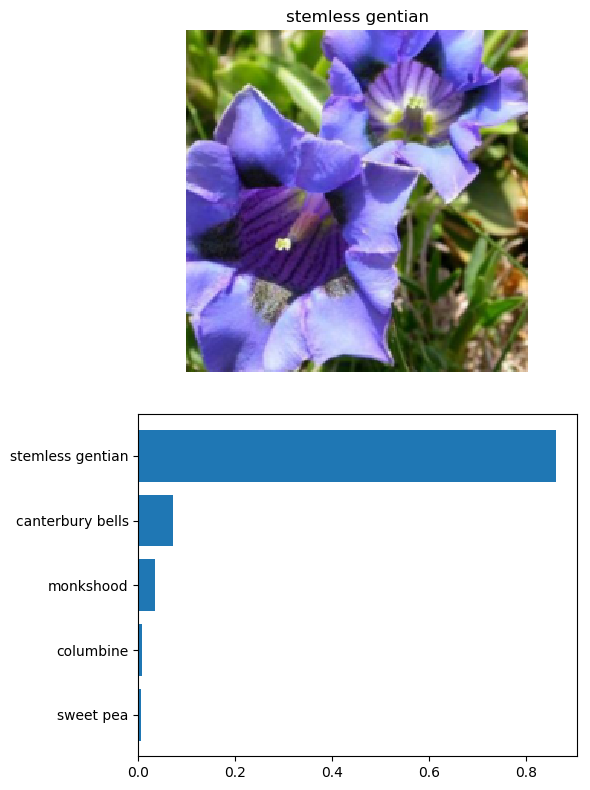

In [72]:
# TODO: Display an image along with the top 5 classes
# Get the TopK predicted classes for the image using trained model
topk = 5
img_class = '28'
file_name = 'image_05230.jpg'
#img_class = '7'
#file_name = 'image_07215.jpg'
image_file = test_dir + '/' + img_class  + '/' + file_name

print(cat_to_name[img_class])
# ####################### Start- Testing Codes Not required for the project #########################
# Process the image using the process_image funtion and display the tranformed image using imshow function
#image = process_image(image_file)
#image
#imshow(image)
#print(cat_to_name[img_class])
#print(image.shape)
#print(image)
# display the original image in native form
#ith Image.open(image_file) as image:
#   plt.imshow(image)
# Display the image sent to model for prediction i.e. tranformed image
#imshow(process_image(image_file))
#print(cat_to_name[img_class])
# ####################### End- Testing Codes Not required for the project #########################


# Use trained model to predict the class of the image
probs, flower_classes = predict(image_file, trained_model, topk)

print(probs)
print(flower_classes)

print("The trained model predicts the provided image to be " + flower_classes[0] + " with a probability of - " + str(probs[0]))
print("Here is the top " + str(topk) + " probabilities of the provided image")
for i in range(topk):
    print("#" + str(i+1) + " for " + flower_classes[i] + " = {:.4f}....".format(probs[i] * 100))

# Visuals for Sanity Checking
plt.rcdefaults()
fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols = 1, nrows = 2)

#First Display the image sent for prediction with title as the highes predicted flower class
ax1.set_title(flower_classes[0])
ax1.axis('off')
imshow(process_image(image_file), ax1)

# Now plot the horizontal bar chart for the top-K flower classes with predicted probabilites

y_pos = np.arange(len(probs))
ax2.barh(y_pos, probs, align = 'center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(flower_classes)
ax2.invert_yaxis()


plt.tight_layout()
plt.show()